#Custom Apriltag image classifier
Author: Sania Zahan Date: 17/11/2025

#Organize Your Dataset:
Create a main directory for your dataset. Inside this main directory, create subdirectories, where each subdirectory represents a class, and contains the images belonging to that class.

Apriltag images: https://github.com/AprilRobotics/apriltag-imgs

Tags and corresponding labels:

tag16h5 -> Left; tag25h9 -> Right;

tag36h11 -> Forward; tagCircle21h7 -> Backward

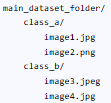

#Download and unzip data
Dataset link: https://github.com/saniazahan/AI-Python/blob/main/Dataset/apriltag_dataset.zip

In [1]:
!unzip apriltag_dataset.zip

Archive:  apriltag_dataset.zip
   creating: apriltag_dataset_v2/
   creating: apriltag_dataset_v2/right/
   creating: apriltag_dataset_v2/backward/
   creating: apriltag_dataset_v2/left/
   creating: apriltag_dataset_v2/stop/
   creating: apriltag_dataset_v2/flashrgb/
   creating: apriltag_dataset_v2/display/
   creating: apriltag_dataset_v2/flashled/
   creating: apriltag_dataset_v2/forward/
   creating: apriltag_dataset_v2/playsound/
  inflating: apriltag_dataset_v2/right/tag36_11_00558.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00564.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00570.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00571.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00565.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00559.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00573.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00567.png  
  inflating: apriltag_dataset_v2/right/tag36_11_00566.png  
  inflating: aprilta

#Import necessary libraries

In [2]:
import tensorflow as tf  # Main TensorFlow library for building and training machine learning models
from tensorflow import keras  # High-level API within TensorFlow for simplifying neural network creation
from tensorflow.keras import layers  # Provides building blocks like Dense, Conv2D, etc. for model architecture
import matplotlib.pyplot as plt  # Plotting library used for visualizing data, metrics, and results
from tensorflow.keras.applications import ResNet50 # Pretrained ResNet50 model for transfer learning and feature extraction

#Load the Dataset with image_dataset_from_directory:

Keras's image_dataset_from_directory utility is designed for this purpose.

In [3]:
# Define parameters for loading the dataset
IMG_HEIGHT = 224    # VGG16 default input size
IMG_WIDTH  = 224
BATCH_SIZE = 32

# Load the training data
train_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset_v2', # Path to your main dataset folder
    labels='inferred',
    label_mode='int', # 'int' for integer-encoded labels (0, 1, 2...), 'binary' for 0/1, 'categorical' for one-hot
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    validation_split=0.2, # Optional: split a portion for validation
    subset='training',
    seed=123 # For reproducible split
)

# Load the validation data (if validation_split was used)
val_ds = tf.keras.utils.image_dataset_from_directory(
    'apriltag_dataset_v2',
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    validation_split=0.2,
    subset='validation',
    seed=123
)

# Get class names
class_names = train_ds.class_names
print(f"Class names: {class_names}")

Found 690 files belonging to 9 classes.
Using 552 files for training.
Found 690 files belonging to 9 classes.
Using 138 files for validation.
Class names: ['backward', 'display', 'flashled', 'flashrgb', 'forward', 'left', 'playsound', 'right', 'stop']


#Prepare the Data for Training:
Optimize performance by prefetching and caching.

In [4]:
AUTOTUNE = tf.data.AUTOTUNE  # Let TensorFlow automatically choose the best speed settings

# Make loading the training data faster by keeping it ready in memory
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Make loading the testing/validation data faster the same way
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Build and Train Your Model:
Define a Convolutional Neural Network (CNN) and train it.

Imagine a Conv2D layer as the model searching an image for specific clues.

It analyses a small area (the 'kernel') to scan over the image, looking for patterns like edges or shapes.

When it finds a pattern, it marks it down. This process creates a new, simplified image that highlights where those patterns were found.

In [5]:
num_classes = len(class_names) # Count how many different kinds of images we have

# Load ResNet50 without top classifier
resnet_base = ResNet50(
    weights="imagenet",        # Use the knowledge it learned from millions of images, imagenet is one of the largest image dataset created so far
    include_top=False,         # Don't use its old final layers; we'll add our own
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)  # Size of our pictures
)
# Freeze convolutional layers (recommended for transfer learning)
resnet_base.trainable = False

model = keras.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

    # Pretrained convolutional feature extractor, Use ResNET as a feature finder (it knows how to spot edges, shapes, patterns)
    resnet_base,

    layers.Flatten(),                          # flatten the feature maps, turn the 2D features into a 1D list
    layers.Dense(128, activation='relu'),      # A normal learning layer that helps make decisions
    layers.Dense(64, activation='relu'),      # A normal learning layer that helps make decisions
    layers.Dense(num_classes, activation='softmax') # Final layer that chooses which class the image belongs to (gives us the probability values)
])

model.summary()

# Tell the model:
# - how to improve itself (optimizer)
# - how to measure mistakes (loss)
# - what score to show us during training (metrics)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # from_logits=False if using softmax
              metrics=['accuracy'])
# Softmax if the raw scores of a tag prediction were:
# Left: 2.5
# Right: 1.0
# Forward: 3.0
# Backward: 0.5

# Softmax would convert them into something like:
# Left: 20%
# Right: 5%
# Forward: 70%
# Backward: 5%

model.summary()

epochs = 10 # Train the model for 10 rounds

# Train the model using our training pictures, and check progress with the validation pictures
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,441,737 (139.01 MB)

 Trainable params: 12,854,025 (49.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           585 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,441,737 (139.01 MB)

 Trainable params: 12,854,025 (49.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 153s 8s/step - accuracy: 0.1268 - loss: 8.2023 - val_accuracy: 0.7246 - val_loss: 0.6496
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 124s 7s/step - accuracy: 0.2676 - loss: 2.5047 - val_accuracy: 0.4710 - val_loss: 1.4798
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.3093 - loss: 1.9003 - val_accuracy: 0.6377 - val_loss: 1.2074
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.3673 - loss: 1.9128 - val_accuracy: 0.4783 - val_loss: 1.3914
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 0.3280 - loss: 1.7710 - val_accuracy: 0.6232 - val_loss: 1.0865
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 125s 7s/step - accuracy: 0.4277 - loss: 1.5888 - val_accuracy: 0.7971 - val_loss: 0.8361
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 0.4581 - loss: 1.5435 - val_accuracy: 0.9058 - val_loss: 0.6679
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 126s 7s/step - accuracy: 0.4461 - loss: 1.5154 - val_accuracy: 0.6014 - v

In [6]:
# === Save the trained Keras model ===

model.save("apriltag_model.keras")   # Modern recommended format

# Optional: Save also to H5 if you want broader compatibility
# model.save("apriltag_model.h5")

print("Model saved successfully as apriltag_model.keras!")

Model saved successfully as apriltag_model.keras!


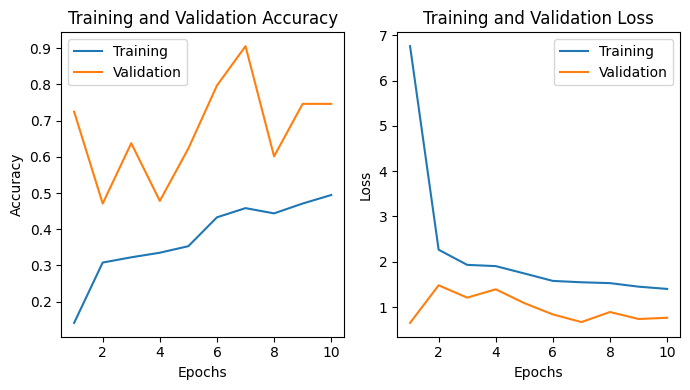

In [7]:
# Get the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate and Predict:
Evaluate the model's performance and make predictions on new images.

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f"Validation accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.7110 - loss: 0.7291
Validation accuracy: 0.7463768124580383


In [12]:
import os
import random
all_images = []
for root, dirs, files in os.walk('apriltag_dataset_v2'):
    for file in files:
        if file.lower().endswith((".jpg", ".jpeg", ".png", ".bmp")):
            all_images.append(os.path.join(root, file))

# Pick 10 random images from the list
random.seed(59) # Ensure selection is reproducible
selected = random.sample(all_images, 10)

# Test each selected image with the trained model
for image_path in selected:
  actual_label = image_path.split('/')[1]   # Get the real label from its folder name

  # Load the image and make it the correct size for the model
  img = tf.keras.utils.load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
  img_array = tf.keras.utils.img_to_array(img)  # Convert to numbers the model understands
  img_array = tf.expand_dims(img_array, 0)      # Models expect a batch, so we add one extra dimension

  predictions = model.predict(img_array)        # Ask the model what it thinks the image is
  score = tf.nn.softmax(predictions[0])         # Turn the raw scores into percentages

  # Print the model’s guess and how sure it is, plus the real answer
  print(f"This image most likely belongs to {class_names[tf.argmax(score)]} "
        f"with a {100 * tf.reduce_max(score):.2f}% confidence. "
        f"Acutal label is {actual_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
This image most likely belongs to flashled with a 15.47% confidence. Acutal label is flashrgb
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step
This image most likely belongs to flashled with a 15.64% confidence. Acutal label is right
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
This image most likely belongs to flashled with a 16.04% confidence. Acutal label is flashled
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
This image most likely belongs to right with a 14.09% confidence. Acutal label is stop
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
This image most likely belongs to backward with a 25.34% confidence. Acutal label is backward
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
This image most likely belongs to right with a 20.52% confidence. Acutal label is right
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
This image most likely belongs to flashled with a 14.46% confidence. Acutal label is playsound
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
This image most likely belongs to flashled wi